# **L&T EduTech Hackathon**
## **Submission for Problem Statement 1 -** Cement Surface Crack Detection
## **Developed by:** Team Avinya

# **Problem Statement**

### The problem statement is relatively simple but is highly relevant and has a huge practical impact factor. Remote enabling of surface crack detections can help in early, accurate and high precision detection without any human inference.

### Given a surface image, the model should be able to find out if the surface has cracks, and accordingly classify it into Positive (has cracks) and Negative (no cracks)

# **Approach**

* ### Since this is an image classification based problem, Deep Learning is a natural choice.
* ### After some research, we have decided to go with a customized VGG16 model via transfer learning. The model provided a better performance than other popular architectures like ResNet and InceptionNet.

# **Dataset**

### Since the provided dataset is quite small, we have also referred to an external dataset for the training of the model. The external dataset consists of 40,000 images equally divided into Positive and Negative Classes.

* ### [Dataset 1](https://www.kaggle.com/datasets/xinzone/surface-crack)
* ### [Dataset 2](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection?datasetId=414522&sortBy=voteCount)

# **Dependencies**

In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# **VGG16 Model Setup**

* ### With reference to the original VGG16 architecture, we obtain the model through transfer learning and retain it upto the 'block5_pool' layer.
* ### Ahead of it, a few customized layers are added sequentially, for task specific model training. 
* ### ReLU and Sigmoid activation functions have been used, along with RMSprop optimizer. The learning rate was found out using hyperparameter tuning and set to 0.0001.

In [7]:
from tensorflow.keras.applications import VGG16

weights_file='/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model=VGG16(input_shape = (120, 120, 3), 
                        include_top = False, 
                        weights =None)

pretrained_model.load_weights(weights_file)

for layer in pretrained_model.layers:
     layer.trainable = False

pretrained_model.summary()

last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

2023-01-19 14:04:48.392601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:04:48.396023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:04:48.396785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 14:04:48.397677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

# **Obtaining DF from Images**
* ### The data being used for training is already good. Both the classes are perfectly balanced in either of the datasets.
* ### Images have been stored into dataframes alongwith labels for further ease of access.

In [8]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')


def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")


all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


# **Splitting into Train and Test**

In [9]:
train_df, test_df = train_test_split(
    all_df.sample(40000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# **Train data**

In [10]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 22400 validated image filenames belonging to 2 classes.


# **Validation data**

In [11]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 5600 validated image filenames belonging to 2 classes.


# **Test data**

In [12]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 12000 validated image filenames belonging to 2 classes.


# **Model Training**

### Using 10 epochs and early loss to prevent overfitting

In [13]:
history = model_vgg.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2023-01-19 14:07:18.732004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-19 14:07:20.688143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


700/700 [==============================] - 165s 225ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.0147 - val_accuracy: 0.9962
Epoch 2/10
700/700 [==============================] - 63s 91ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.0135 - val_accuracy: 0.9962
Epoch 3/10
700/700 [==============================] - 62s 88ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0145 - val_accuracy: 0.9962
Epoch 4/10
700/700 [==============================] - 62s 89ms/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0134 - val_accuracy: 0.9961
Epoch 5/10
700/700 [==============================] - 61s 87ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0129 - val_accuracy: 0.9964
Epoch 6/10
700/700 [==============================] - 62s 89ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0133 - val_accuracy: 0.9970
Epoch 7/10
700/700 [==============================] - 68s 97ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.0143 - val_accuracy: 0.9961
E

# **Custom Image Input**
### Simple way to directly give a random image as an input to the model for detection

In [34]:
img = cv2.imread('/kaggle/input/personal-for-crack-images/nocrack.jpg')
img = cv2.resize(img, (120,120))
img = np.array(img)
img = np.expand_dims(img,axis=0)
y_pred = np.squeeze((model_vgg.predict(img) >= 0.5).astype(np.int))
print(y_pred) # 0 is for no crack and 1 for crack

0


# **Model Evaluation Function**

In [17]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

# **Generate Test DF**
## Obtaining Test dataframe from the test data of given dataset for model evaluation

In [20]:
#Obtain actual test DF for checking
actual_positive_dir = Path('/kaggle/input/surface-crack/test/Positive')
actual_negative_dir = Path('/kaggle/input/surface-crack/test/Negative')

actual_positive_df = generate_df(actual_positive_dir, label="POSITIVE")
actual_negative_df = generate_df(actual_negative_dir, label="NEGATIVE")

actual_all_df = pd.concat([actual_positive_df, actual_negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
actual_all_df

actual_test_data = train_gen.flow_from_dataframe(
    actual_all_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 200 validated image filenames belonging to 2 classes.


# **Model Performance Evaluation**

    Test Loss: 0.02050
Test Accuracy: 99.00%


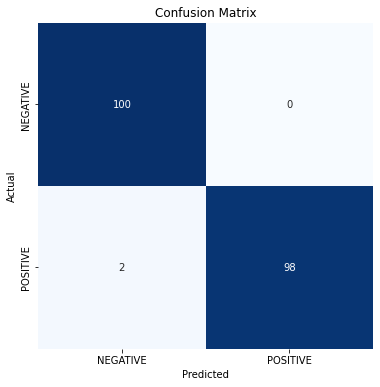

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      1.00      0.99       100
    POSITIVE       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [25]:
evaluate_model(model_vgg, actual_test_data)

## Thus, the model has the following performance metrics:
* ### Precision - 98% for NEGATIVE and 100% for POSITIVE
* ### Recall - 100% for NEGATIVE and 98% for POSITIVE
* ### F1 Score - 99%
* ### Accuracy of 99%
* ### Test Loss - 0.02050

# **Saving and Loading Model**
### The model can easily be exported for direct use elsewhere without having the need to retrain the model.

In [44]:
!ls /kaggle/working
model_vgg.save('/kaggle/working/Crack_Detection_VGG16_model_final.h5')

Crack_Detection_VGG16_model_1630PM.h5  model_pickle
__notebook_source__.ipynb	       model_pickle_1


In [43]:
from keras.models import load_model
mp = load_model('/kaggle/working/Crack_Detection_VGG16_model_final.h5')

1
